In [1]:
import copy
import pickle
import sys
from collections import defaultdict
from itertools import combinations

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.python.framework.errors_impl import NotFoundError

from src.cfd import CFD
from src.dataset import X_TIME, load_expanded_dataset_train_val, TIME_STEP, load_expanded_dataset_train_test, \
    _extract_dataset_by_idx
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_all_ch
from src.network_utils import train_model as _base_train_model, gaussian_kernel, plot_difference_hist

PWD = '../../..'
sys.path.append(PWD)

OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

In [2]:
BASE_CFD_THRESHOLD = 0.2
CFD_N_BASELINE = 6

base_cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=BASE_CFD_THRESHOLD)

In [3]:
N_BASELINE = 6

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 1000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

LR_PATIENCE = 5
ES_PATIENCE = 50

OVERWRITE = False

In [4]:
base_dataset, _ = load_expanded_dataset_train_test(PWD)
train_dataset, val_dataset = load_expanded_dataset_train_val(PWD)
train_dataset[0].shape, val_dataset[0].shape

((26719,), (6680,))

In [5]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

cfd_by_channel = {(p, ch): CFD(n_baseline=N_BASELINE, threshold=thresh) for (p, ch), thresh in
                  optimal_cfd_thresholds.items()}

Optimal thresholds:
(1,  2): 0.180
(1, 11): 0.185
(2,  2): 0.220
(2, 11): 0.145
(3,  2): 0.130
(3, 11): 0.175


# Utils

In [6]:
def compute_true_t(t_avg: float, t_ch: float, t_0: float) -> float:
    # use only timestamps from other channels
    return ((3 * t_avg) - (t_ch + t_0)) / 2 - t_0


def compute_true_dataset(dataset_t_avg: np.ndarray, dataset_t0: dict, dataset_t_pred: dict) -> dict:
    true_dataset = defaultdict(list)
    for key in dataset_t0.keys():
        print(f'Processing {key}...')

        for i, t_avg in enumerate(dataset_t_avg):
            if np.isnan(dataset_t0[key][i]):
                true_dataset[key].append(np.nan)
            else:
                t_0 = dataset_t0[key][i]
                t_pred = dataset_t_pred[key][i]
                true_dataset[key].append(compute_true_t(t_avg, t_pred, t_0))

    return true_dataset


def build_nn_dataset(dataset_wav: dict, dataset_true: dict) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    x, y = [], []
    for key, data in dataset_wav.items():
        t_data = dataset_true[key]
        for i in range(len(t_data)):
            if np.isnan(t_data[i]):
                continue
            wav = data[i]
            true_t = t_data[i]

            x.append(wav)
            y.append(true_t)

    x, y = np.array(x), np.array(y)

    # UNet
    y_network = np.array([gaussian_kernel(t) for t in y])

    return x, y, y_network


def build_and_train_network(iteration: int, x_train: np.ndarray, x_val: np.ndarray, y_train: np.ndarray,
                            y_val: np.ndarray, overwrite: bool = OVERWRITE,
                            verbose: int = 2) -> tuple[keras.Model, pd.DataFrame]:
    model = optimal_model_builder_all_ch()
    name = f"optimal_it_{iteration}"
    if overwrite:
        history = _base_train_model(model, name, "iti_experiments", x_train, y_train, x_val, y_val, LR, True, N_EPOCHS,
                                    verbose, BATCH_SIZE, LR_PATIENCE, ES_PATIENCE, ES_MIN_DELTA, LOSS_WEIGHT,
                                    root=PWD + '/data')
    else:
        try:
            history = _base_train_model(model, name, "iti_experiments", x_train, y_train, x_val, y_val, LR, False,
                                        N_EPOCHS,
                                        verbose, BATCH_SIZE, LR_PATIENCE, ES_PATIENCE, ES_MIN_DELTA, LOSS_WEIGHT,
                                        root=PWD + '/data')
        except NotFoundError:
            history = _base_train_model(model, name, "iti_experiments", x_train, y_train, x_val, y_val, LR, True,
                                        N_EPOCHS,
                                        verbose, BATCH_SIZE, LR_PATIENCE, ES_PATIENCE, ES_MIN_DELTA, LOSS_WEIGHT,
                                        root=PWD + '/data')

    return model, history


def pred_model(model: keras.Model, x: np.ndarray) -> np.ndarray:
    y_pred = model.predict(x, batch_size=BATCH_SIZE)

    # UNet
    y_pred_t = np.empty(y_pred.shape[0])
    for i, y in enumerate(y_pred):
        _, y_pred_t[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred_t


def evaluate_model_wrt_cfd_average(model: keras.Model, x: np.ndarray, y_true_t: np.ndarray, show: bool = True) -> float:
    y_pred = pred_model(model, x)
    std, _, _ = plot_difference_hist(y_true_t, y_pred, show=show)
    return std


def build_updated_dataset(model: keras.Model, dataset: tuple[np.ndarray, dict, dict, dict]) -> tuple[
    np.ndarray, dict, dict, dict]:
    _, dataset_wav, dataset_t0, _ = dataset
    dataset_t0_updated = {}
    dataset_t_pred_updated = {}
    dataset_len = list(dataset_wav.values())[0].shape[0]
    dataset_avg = np.zeros(dataset_len)
    dataset_avg_count = np.zeros(dataset_len)

    for key in dataset_wav.keys():
        print(f'Processing channel {key}...')
        # compute updated t0
        wav_array = dataset_wav[key]
        t0_array = dataset_t0[key].copy()

        mask = ~np.isnan(t0_array)
        t0_temp = t0_array[mask]
        t_pred_array_temp = pred_model(model, wav_array[mask])
        t_pred_array = np.full(dataset_len, np.nan)
        t_pred_array[mask] = t_pred_array_temp

        t_fixed = t0_temp + t_pred_array_temp
        t_mean = np.mean(t_fixed)

        t0_array[mask] -= t_mean
        dataset_t0_updated[key] = t0_array
        dataset_t_pred_updated[key] = t_pred_array

        # add to avg
        dataset_avg[mask] += t0_array[mask] + t_pred_array_temp
        dataset_avg_count[mask] += 1

    dataset_avg /= dataset_avg_count

    return dataset_avg, dataset_wav, dataset_t0_updated, dataset_t_pred_updated


def compute_average_pairwise_precision(dataset_t_pred: dict, dataset_t0: dict) -> float:
    dataset_t = copy.deepcopy(dataset_t0)
    for key in dataset_t_pred.keys():
        mask = ~np.isnan(dataset_t0[key])
        dataset_t[key][mask] += dataset_t_pred[key][mask]

    pairwise_precisions = {}
    for p_ch1, p_ch2 in combinations(dataset_t.keys(), 2):
        if p_ch1[1] == p_ch2[1]:  # Only for corresponding channels
            ch1_timestamps, ch2_timestamps = dataset_t[p_ch1], dataset_t[p_ch2]
            differences = [abs(ch1_t - ch2_t) for ch1_t, ch2_t in zip(ch1_timestamps, ch2_timestamps) if
                           not np.isnan(ch1_t) and not np.isnan(ch2_t)]

            pairwise_precisions[(p_ch1, p_ch2)] = np.std(differences)

    return np.average(pairwise_precisions.values())

In [10]:
true_cfd_train = compute_true_dataset(train_dataset[0], train_dataset[2], train_dataset[3])
true_cfd_val = compute_true_dataset(val_dataset[0], val_dataset[2], val_dataset[3])
x_train, y_train_t, y_train = build_nn_dataset(train_dataset[1], true_cfd_train)
x_val, y_val_t, y_val = build_nn_dataset(val_dataset[1], true_cfd_val)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

Processing (1, 2)...
Processing (1, 11)...
Processing (2, 2)...
Processing (2, 11)...
Processing (3, 2)...
Processing (3, 11)...
Processing (1, 2)...
Processing (1, 11)...
Processing (2, 2)...
Processing (2, 11)...
Processing (3, 2)...
Processing (3, 11)...


((80157, 24), (20040, 24), (80157, 24), (20040, 24))

# Test

## Iteration 1

### 1.1. Train Model

In [11]:
model_it1, _ = build_and_train_network(iteration=1, x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)

### 1.2. Evaluate wrt CFD averages

3/3 [==============================] - 1s 177ms/step


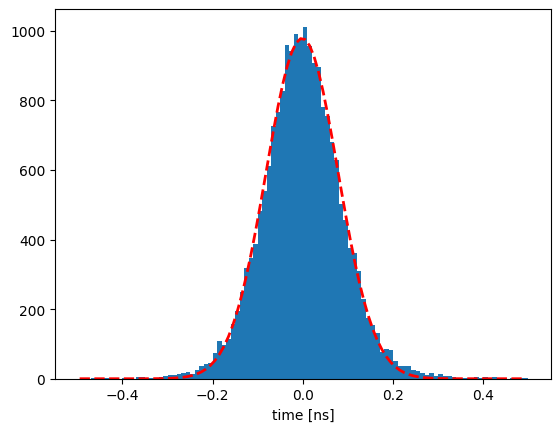

Iteration 1. std wrt. CFD average: 79.88 ps


In [12]:
std = evaluate_model_wrt_cfd_average(model_it1, x_val, y_val_t)
print(f"Iteration 1. std wrt. CFD average: {std * 1000:0.2f} ps")

### 1.3. Update dataset

In [13]:
base_dataset_it1 = build_updated_dataset(model_it1, base_dataset)

Processing channel (1, 2)...
2/2 [==============================] - 0s 409ms/step
Processing channel (1, 11)...
3/3 [==============================] - 0s 212ms/step
Processing channel (2, 2)...
2/2 [==============================] - 0s 445ms/step
Processing channel (2, 11)...
3/3 [==============================] - 0s 229ms/step
Processing channel (3, 2)...
2/2 [==============================] - 0s 336ms/step
Processing channel (3, 11)...
3/3 [==============================] - 0s 220ms/step


In [14]:
train_idx, val_idx = train_test_split(np.arange(len(base_dataset_it1[0])), test_size=0.2, random_state=42)
train_dataset_it1 = _extract_dataset_by_idx(base_dataset_it1, train_idx)
val_dataset_it1 = _extract_dataset_by_idx(base_dataset_it1, val_idx)

true_t_train_it1 = compute_true_dataset(train_dataset_it1[0], train_dataset_it1[2], train_dataset_it1[3])
true_t_val_it1 = compute_true_dataset(val_dataset_it1[0], val_dataset_it1[2], val_dataset_it1[3])
x_train_it1, y_train_t_it1, y_train_it1 = build_nn_dataset(train_dataset_it1[1], true_t_train_it1)
x_val_it1, y_val_t_it1, y_val_it1 = build_nn_dataset(val_dataset_it1[1], true_t_val_it1)

x_train_it1.shape, y_train_it1.shape, x_val_it1.shape, y_val_it1.shape

Processing (1, 2)...
Processing (1, 11)...
Processing (2, 2)...
Processing (2, 11)...
Processing (3, 2)...
Processing (3, 11)...
Processing (1, 2)...
Processing (1, 11)...
Processing (2, 2)...
Processing (2, 11)...
Processing (3, 2)...
Processing (3, 11)...


((80157, 24), (80157, 24), (20040, 24), (20040, 24))

### 1.4 Evaluate pairwise precision

## Iteration 2

### 2.1. Train model

In [15]:
model_it2, _ = build_and_train_network(iteration=2, x_train=x_train_it1, x_val=x_val_it1, y_train=y_train_it1,
                                       y_val=y_val_it1)

### 2.2. Evaluate wrt CFD averages

3/3 [==============================] - 1s 191ms/step


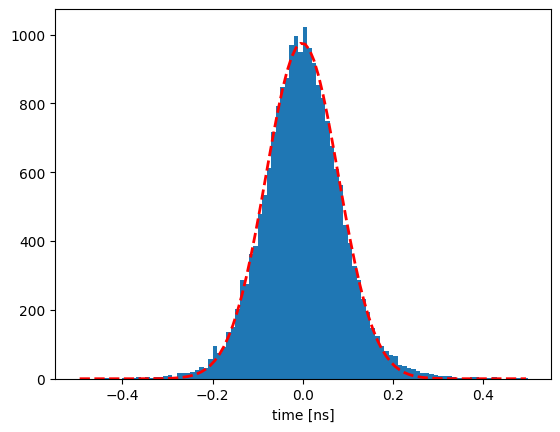

Iteration 1. std wrt. CFD average: 80.17 ps


In [16]:
std = evaluate_model_wrt_cfd_average(model_it2, x_val, y_val_t)
print(f"Iteration 1. std wrt. CFD average: {std * 1000:0.2f} ps")

### 2.3. Evaluate pairwise precision

### 2.4. Update dataset

In [17]:
base_dataset_it2 = build_updated_dataset(model_it2, base_dataset_it1)

Processing channel (1, 2)...
2/2 [==============================] - 0s 377ms/step
Processing channel (1, 11)...
3/3 [==============================] - 0s 87ms/step
Processing channel (2, 2)...
2/2 [==============================] - 0s 303ms/step
Processing channel (2, 11)...
3/3 [==============================] - 0s 180ms/step
Processing channel (3, 2)...
2/2 [==============================] - 0s 248ms/step
Processing channel (3, 11)...
3/3 [==============================] - 0s 145ms/step


In [18]:
train_idx, val_idx = train_test_split(np.arange(len(base_dataset_it2[0])), test_size=0.2, random_state=42)
train_dataset_it2 = _extract_dataset_by_idx(base_dataset_it2, train_idx)
val_dataset_it2 = _extract_dataset_by_idx(base_dataset_it2, val_idx)

true_t_train_it2 = compute_true_dataset(train_dataset_it2[0], train_dataset_it2[2], train_dataset_it2[3])
true_t_val_it2 = compute_true_dataset(val_dataset_it2[0], val_dataset_it2[2], val_dataset_it2[3])
x_train_it2, y_train_t_it2, y_train_it2 = build_nn_dataset(train_dataset_it2[1], true_t_train_it2)
x_val_it2, y_val_t_it2, y_val_it2 = build_nn_dataset(val_dataset_it2[1], true_t_val_it2)

x_train_it2.shape, y_train_it2.shape, x_val_it2.shape, y_val_it2.shape

Processing (1, 2)...
Processing (1, 11)...
Processing (2, 2)...
Processing (2, 11)...
Processing (3, 2)...
Processing (3, 11)...
Processing (1, 2)...
Processing (1, 11)...
Processing (2, 2)...
Processing (2, 11)...
Processing (3, 2)...
Processing (3, 11)...


((80157, 24), (80157, 24), (20040, 24), (20040, 24))

## Iteration 3

### 3.1 Train model

In [19]:
model_it3, _ = build_and_train_network(iteration=3, x_train=x_train_it2, x_val=x_val_it2, y_train=y_train_it2,
                                       y_val=y_val_it2)

### 3.2. Evaluate wrt CFD averages

3/3 [==============================] - 1s 187ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


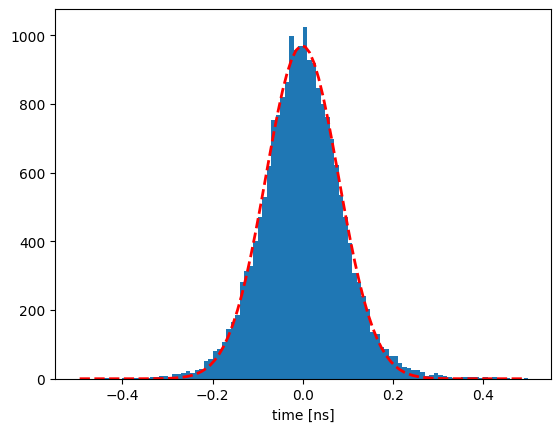

Iteration 1. std wrt. CFD average: 80.66 ps


In [20]:
std = evaluate_model_wrt_cfd_average(model_it3, x_val, y_val_t)
print(f"Iteration 1. std wrt. CFD average: {std * 1000:0.2f} ps")

### 3.3. Evaluate pairwise precision

### 3.4. Update dataset

In [21]:
base_dataset_it3 = build_updated_dataset(model_it3, base_dataset_it2)

Processing channel (1, 2)...
2/2 [==============================] - 0s 432ms/step
Processing channel (1, 11)...
3/3 [==============================] - 0s 158ms/step
Processing channel (2, 2)...
2/2 [==============================] - 0s 298ms/step
Processing channel (2, 11)...
3/3 [==============================] - 0s 136ms/step
Processing channel (3, 2)...
2/2 [==============================] - 0s 249ms/step
Processing channel (3, 11)...
3/3 [==============================] - 0s 163ms/step


In [22]:
train_idx, val_idx = train_test_split(np.arange(len(base_dataset_it3[0])), test_size=0.2, random_state=42)
train_dataset_it3 = _extract_dataset_by_idx(base_dataset_it3, train_idx)
val_dataset_it3 = _extract_dataset_by_idx(base_dataset_it3, val_idx)

true_t_train_it3 = compute_true_dataset(train_dataset_it3[0], train_dataset_it3[2], train_dataset_it3[3])
true_t_val_it3 = compute_true_dataset(val_dataset_it3[0], val_dataset_it3[2], val_dataset_it3[3])
x_train_it3, y_train_t_it3, y_train_it3 = build_nn_dataset(train_dataset_it3[1], true_t_train_it3)
x_val_it3, y_val_t_it3, y_val_it3 = build_nn_dataset(val_dataset_it3[1], true_t_val_it3)

x_train_it3.shape, y_train_it3.shape, x_val_it3.shape, y_val_it3.shape

Processing (1, 2)...
Processing (1, 11)...
Processing (2, 2)...
Processing (2, 11)...
Processing (3, 2)...
Processing (3, 11)...
Processing (1, 2)...
Processing (1, 11)...
Processing (2, 2)...
Processing (2, 11)...
Processing (3, 2)...
Processing (3, 11)...


((80157, 24), (80157, 24), (20040, 24), (20040, 24))